# Survival Model #

@roman_avj

7 nov 2023

In [13]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import boto3
import sqlalchemy

from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

from xgbse import XGBSEStackedWeibull
from xgbse.extrapolation import extrapolate_constant_risk
import lifelines

from scipy.integrate import simpson
from scipy.optimize import brentq

import geopandas as gpd
import folium

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from xgbse.metrics import (
    approx_brier_score,
    dist_calibration_score,
    concordance_index
)


# Setup

## Data

In [2]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2.parquet')
df_model.info()

# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

# look rows with maximum time2event
df_max = df_model[df_model['time2event'] == df_model['time2event'].max()]



[FATAL] 2023-11-08 21:06:07.701 Aws::Config::ConfigFileProfileFSM [0x202b1f280] Unknown parser error: unexpected state 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 79.3+ MB


## Wrangle

In [3]:
# get maxmimum time2event
# get a random id from df_max, first trye for event == 1, then for event == 0
id_max = df_max[df_max['event'] == 1]['id'].sample(1, random_state=8).values[0]
if pd.isna(id_max):
    id_max = df_max[df_max['event'] == 0]['id'].sample(1, random_state=8).values[0]

# for id_max add 1 to time2event and set event = 1
df_model.loc[df_model['id'] == id_max, 'time2event'] =\
     df_model.loc[df_model['id'] == id_max, 'time2event'] + 1

df_model.loc[df_model['id'] == id_max, 'event'] = 1

## Transform

In [4]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bedrooms', 'sine_tmonth', 'cosine_tmonth']
vars_x_numerical = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex', 
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'surface_total', 'page_on_marketplace',
    'is_new_property_prob', 'total_cost_of_living', 'days_active', 'relative_cost_of_living']
vars_x_binary = ['is_exterior', 'has_gym', 'pets_allowed', 'has_maintenance']
vars_x_geographic = ['latitude', 'longitude']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic
vars_x_names_id = vars_x_names

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

23
23


In [5]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical + vars_x_discrete + vars_x_binary + vars_x_geographic})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       73938 non-null  category
 1   property_type                      73938 non-null  category
 2   woe_marketplace                    73938 non-null  float64 
 3   woe_seller                         73938 non-null  float64 
 4   woe_id_sepomex                     73938 non-null  float64 
 5   first_price                        73938 non-null  float64 
 6   diff_first_prediction              73938 non-null  float64 
 7   prediction_price_per_square_meter  73938 non-null  float64 
 8   surface_total                      73938 non-null  float64 
 9   page_on_marketplace                73938 non-null  float64 
 10  is_new_property_prob               73938 non-null  float64 
 11  total_cost_of_living               73938 

In [6]:
# one hot encoding
data_x_numeric = OneHotEncoder().fit_transform(data_x)

colnames_x_numeric = data_x_numeric.columns
data_x_numeric = data_x_numeric.to_numpy()

# boxcox
location_cols_boxcox = [colnames_x_numeric.get_loc(col) for col in vars_x_numerical]

data_x_numeric_aux = data_x_numeric[:, location_cols_boxcox] / 1e+6
data_x_numeric_aux = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_boxcox] = data_x_numeric_aux

# scale
location_cols_scale = [colnames_x_numeric.get_loc(col) for col in vars_x_discrete + vars_x_geographic]
data_x_numeric_aux = data_x_numeric[:, location_cols_scale]
data_x_numeric_aux = StandardScaler().fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_scale] = data_x_numeric_aux

In [7]:
# give the id's of the rows
data_x_numeric = np.hstack((data_x_numeric, df_model['id'].to_numpy().reshape(-1,1)))

# get the row with id_max
data_x_max = data_x_numeric[df_model['id'] == id_max]
idx_delete = df_model[df_model['id'] == id_max].index

# delete row_id_max from data_x_numeric
data_x_numeric = np.delete(data_x_numeric, idx_delete, axis=0)

# also delete from data_y
data_y_max = data_y[idx_delete]
data_y = np.delete(data_y, idx_delete, axis=0)

## Train & Test

In [8]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.2, random_state=42
)

In [9]:
# get the id's of the train and test
train_ids = X_train[:, -1]
test_ids = X_test[:, -1]

# add id_max to X_train & y_train
X_train = np.vstack([X_train, data_x_max])
y_train = np.hstack([y_train, data_y_max])

# delete the id's from the data
X_train = np.delete(X_train, -1, axis=1)
X_test = np.delete(X_test, -1, axis=1)

In [10]:
# get valiadtion data
X_train_bis, X_val, y_train_bis, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Get Best Model

In [11]:
# create vanilla model
class sklearn_wei(XGBSEStackedWeibull):
  
    def get_params2(self):
        return(self.get_params()['xgb_params'])
      
    def set_params(self,**params):
      old_params = self.get_params2()
      old_params.update(params)
      self.xgb_params = old_params
      return(self)

ok = sklearn_wei()

In [12]:
# cross validation
opt = BayesSearchCV(
  estimator = ok,
  scoring = make_scorer(concordance_index),
  n_iter = 5,
  random_state = 42,
  cv = StratifiedKFold(n_splits = 4, shuffle = True),
  n_jobs = -1,
  n_points = 1,
  verbose = 1,
  search_spaces = {
    'max_depth': Integer(low = 2, high = 10, prior = 'log-uniform'),
    'learning_rate': Real(0.01, 1, "log-uniform"),
    'reg_alpha': Real(low=0, high = 1,prior = "uniform"),
    'reg_lambda': Real(low=0, high = 1,prior = "uniform"),
  },
  fit_params = {}
 )

opt.fit(
  X_train_bis,
  y_train_bis,
  time_bins = range(1, 171, 1),
  validation_data= (X_val, y_val),
  early_stopping_rounds=10,
  verbose_eval=50
)

NameError: name 'concordance_index' is not defined

In [ ]:
df_results = (
  pd.DataFrame(opt.cv_results_).sort_values(by = 'rank_test_score', ascending = True)
  .assign(
    max_depth=lambda x: x['params'].apply(lambda y: y['max_depth']),
    learning_rate=lambda x: x['params'].apply(lambda y: y['learning_rate']),
    reg_alpha=lambda x: x['params'].apply(lambda y: y['reg_alpha']),
    reg_lambda=lambda x: x['params'].apply(lambda y: y['reg_lambda'])
    )
    [[
      'max_depth', 'learning_rate', 'reg_alpha', 'reg_lambda',
      'mean_test_score', 'std_test_score', 'mean_fit_time']]
  )

df_results

,max_depth,learning_rate,reg_alpha,reg_lambda,mean_test_score,std_test_score,mean_fit_time
2,9,0.077565,0.104859,0.433333,0.719255,0.002007,13.200773
0,6,0.066101,0.932868,0.315800,0.717694,0.001607,24.793023
1,8,0.472908,0.303410,0.951224,0.710684,0.004785,1.061896
4,4,0.397289,0.526620,0.715713,0.709699,0.001586,1.740833
3,3,0.421495,0.598047,0.802765,0.709408,0.002401,3.963193


# Train Best Model

## Fit

In [14]:
# best params
best_xgbse_params = opt.best_estimator_.get_params2()
best_xgbse_params

NameError: name 'opt' is not defined

In [15]:
# fit weibull
xgbse_weibull = XGBSEStackedWeibull() # use vanilla method, has performed better
xgbse_weibull.fit(
    X_train_bis, y_train_bis,
    validation_data=(X_val, y_val),
    early_stopping_rounds=10,
    verbose_eval=50,
    time_bins = range(1, 171, 1)
)

[0]	validation-aft-nloglik:12.94941
[50]	validation-aft-nloglik:3.46488
[100]	validation-aft-nloglik:3.38969
[150]	validation-aft-nloglik:3.38748
[160]	validation-aft-nloglik:3.38755


XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.05, 'max_depth': 8,
                                'min_child_weight': 50,
                                'objective': 'survival:aft', 'subsample': 0.5,
                                'tree_method': 'hist'})

## Train

In [16]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

def get_metrics(df):
    df = df.copy()
    cindex = concordance_index_censored(df['event'], df['observed_time'], df['risk_score'])[0]
    # rmse & mape for all with event as True
    rmse = np.sqrt(np.mean((df[df['event']]['predicted_time'] - df[df['event']]['observed_time'])**2))
    mape = np.mean(np.abs((df[df['event']]['predicted_time'] - df[df['event']]['observed_time']) / df[df['event']]['observed_time']))
    return pd.Series({'rmse': rmse, 'mape': mape, 'cindex': cindex})

def get_prediction_df(X, y, colnames, model):
    # get rmse, mape and cindex by listing & property type
    df_pred = (
        pd.DataFrame(X, columns=colnames)
        .assign(
            observed_time=y['Survival_in_days'],
            event=y['Status'],
            predicted_time=model.predict(X).pipe(get_xgbse_mean_time),
            risk_score=lambda x: - x['predicted_time']
        )
        .rename(columns={
        'listing_type=for-sale': 'listing_type',
        'property_type=house': 'property_type',
        })
        .assign(
            listing_type=lambda x: np.where(x['listing_type'] == 1, 'for-sale', 'for-rent'),
            property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
        )  
    )

    return df_pred


In [33]:
# get prediction df
df_pred = get_prediction_df(X_train, y_train, colnames_x_numeric, xgbse_weibull)

# get metrics
table_metrics = (
    df_pred
    .groupby(['listing_type', 'property_type'])
    .apply(get_metrics)
)

# save
os.makedirs("../../results/best_models", exist_ok=True)
table_metrics.to_csv("../../results/best_models/best_survival_model_metrics.csv")
table_metrics

rmse      mape    cindex
listing_type property_type                               
for-rent     apartment      24.156692  1.047171  0.687417
             house          25.648177  1.034785  0.693580
for-sale     apartment      40.712204  1.035310  0.726450
             house          39.434129  0.982119  0.728288

## Test

### General Metrics

In [18]:
# get prediction df
df_pred = get_prediction_df(X_test, y_test, colnames_x_numeric, xgbse_weibull)

# get metrics
(
    df_pred
    .groupby(['listing_type', 'property_type'])
    .apply(get_metrics)
)

rmse      mape    cindex
listing_type property_type                               
for-rent     apartment      25.232897  1.082806  0.646486
             house          27.493236  1.014034  0.635238
for-sale     apartment      43.441838  1.158412  0.703827
             house          43.101182  1.087928  0.694031

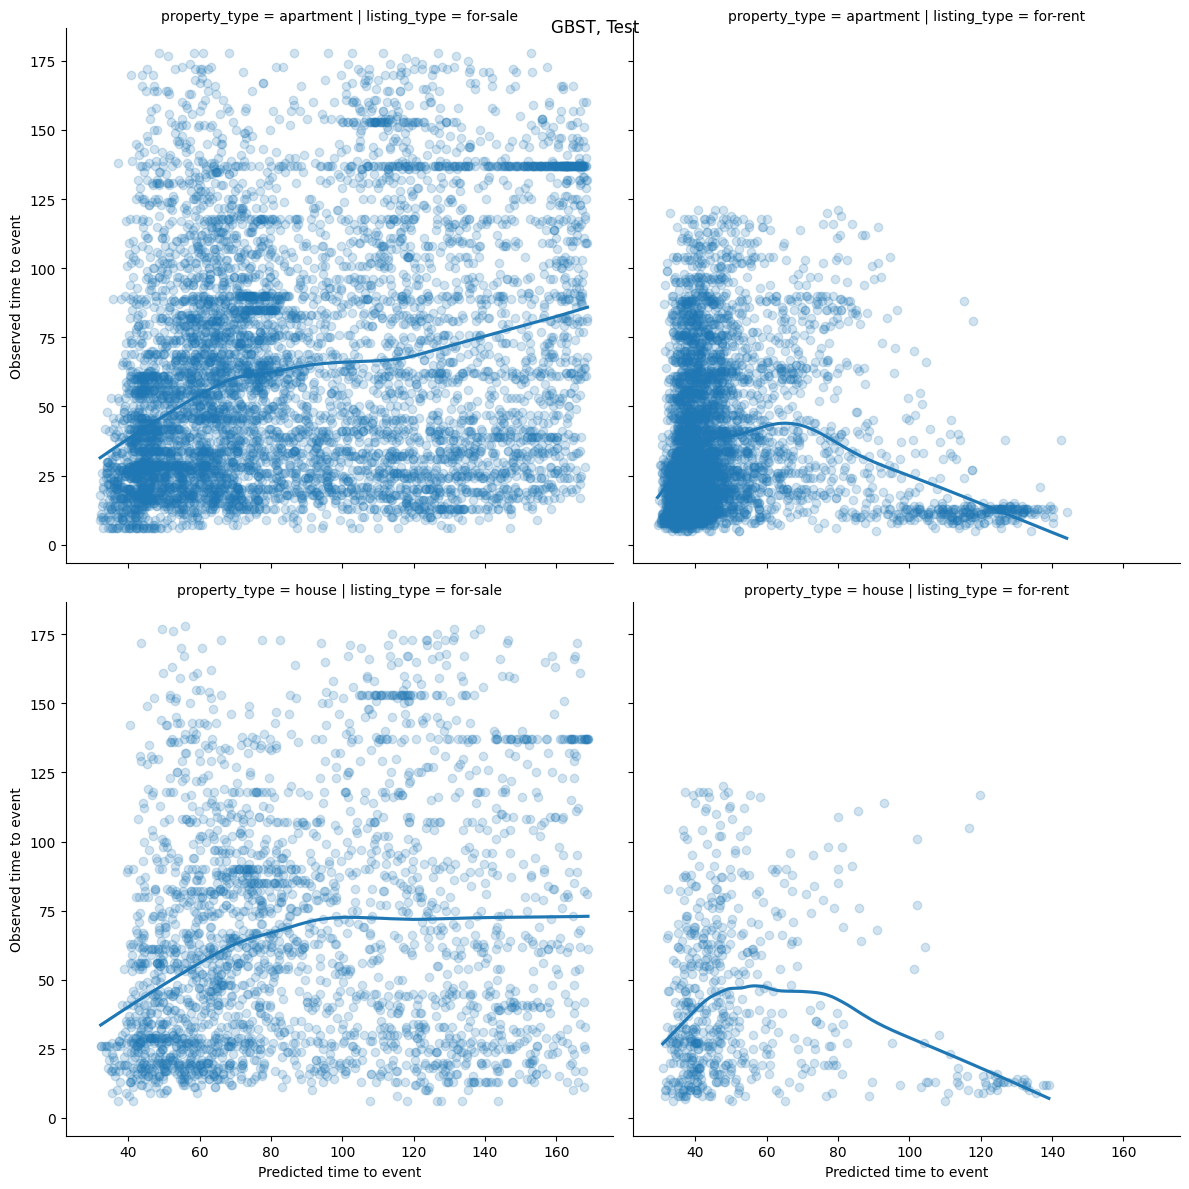

In [19]:
# plot a regplot observed vs predicted, facet grid listing_type and property_type
g = sns.FacetGrid(df_pred, col='listing_type', row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('GBST, Test')
plt.show()

In [20]:
# get feature importance
pd.Series(xgbse_weibull.feature_importances_.values(), index=colnames_x_numeric).sort_values(ascending=False)

diff_first_prediction                940.0
is_new_property_prob                 932.0
first_price                          893.0
longitude                            834.0
sine_tmonth                          829.0
latitude                             827.0
prediction_price_per_square_meter    773.0
surface_total                        722.0
total_cost_of_living                 716.0
page_on_marketplace                  711.0
days_active                          666.0
relative_cost_of_living              584.0
woe_marketplace                      509.0
woe_seller                           461.0
cosine_tmonth                        426.0
woe_id_sepomex                       316.0
num_bedrooms                         111.0
pets_allowed                          98.0
has_maintenance                       92.0
has_gym                               67.0
property_type=house                   38.0
listing_type=for-sale                 25.0
is_exterior                            7.0
dtype: floa

### Brier Score

In [21]:
# get brier score ofr property_type and listing_type
def get_brier_score(df, colnames, model):
    brier_score = approx_brier_score(
        y_true=np.array(
                list(zip(df['event'], df['observed_time'])),
                dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
                ),
        survival=model.predict(df[colnames].values),
    )
    return brier_score

# get brier score by listing_type and property_type
(
    df_pred
    .assign(
        listing_type2=lambda x: np.where(x['listing_type'] == 'for-sale', 1, 0),
        property_type2=lambda x: np.where(x['property_type'] == 'house', 1, 0),
    )
    .rename(columns={
        'listing_type2': 'listing_type=for-sale',
        'property_type2': 'property_type=house',
    })
    .sample(frac=0.95, random_state=42)
    .groupby(['listing_type', 'property_type'])
    .apply(lambda x: get_brier_score(x, colnames=colnames_x_numeric, model=xgbse_weibull))
)

/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/non_parametric.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/non_parametric.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/non_parametric.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-pac

listing_type  property_type
for-rent      apartment        0.097886
              house            0.104071
for-sale      apartment        0.156292
              house            0.154982
dtype: float64

# Survival Curves

In [22]:
def get_survival_df(X, y, model, ids, df, cols):
    # predict 
    df_predictions = xgbse_weibull.predict(X)

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            observed_time=y['Survival_in_days'],
            event=y['Status'],
        )
        .merge(
            df[['id'] + cols],
            how='inner',
            on='id'
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# from colnames_x_numeric change 'listing_type=for-sale' for 'listing_type' and 'property_type=house' for 'property_type'
colnames_x_numeric_tidy = [col.replace('listing_type=for-sale', 'listing_type').replace('property_type=house', 'property_type') for col in colnames_x_numeric]
colnames_x_numeric_tidy

# get predictions
df_surv = get_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy)
df_surv

# cols with 'day_*'
cols_day = [col for col in df_surv.columns if 'day_' in col]

### Random

In [23]:
df_surv_long = (
    df_surv
    .groupby(['listing_type', 'property_type'])
    .sample(10, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'listing_type', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
)
df_surv_long

,id,listing_type,property_type,day,survival
39,025081b4fea75d4881a713ac97f2f51a,for-sale,house,1,0.998815
79,025081b4fea75d4881a713ac97f2f51a,for-sale,house,2,0.996508
119,025081b4fea75d4881a713ac97f2f51a,for-sale,house,3,0.993435
159,025081b4fea75d4881a713ac97f2f51a,for-sale,house,4,0.989735
199,025081b4fea75d4881a713ac97f2f51a,for-sale,house,5,0.985490
...,...,...,...,...,...
6634,fe2030583652c2c6372aa7f5b878c459,for-sale,house,166,0.000578
6674,fe2030583652c2c6372aa7f5b878c459,for-sale,house,167,0.000538
6714,fe2030583652c2c6372aa7f5b878c459,for-sale,house,168,0.000502
6754,fe2030583652c2c6372aa7f5b878c459,for-sale,house,169,0.000467


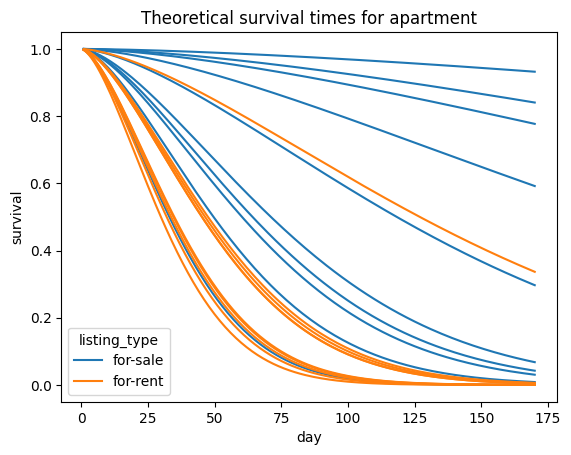

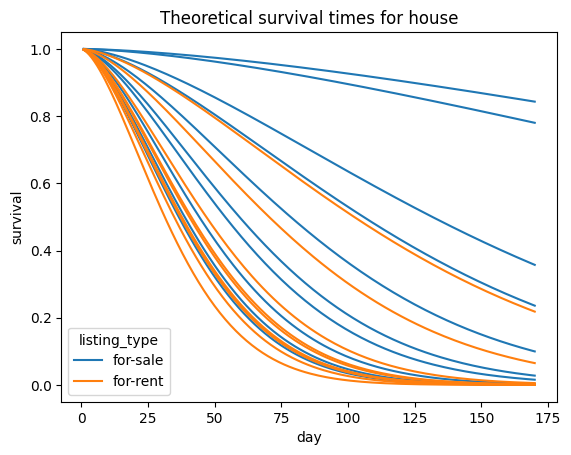

In [24]:
for name, group in df_surv_long.groupby(['property_type']):
    sns.lineplot(x='day', y='survival', data=group, units='id', hue='listing_type', estimator=None)
    plt.title(f"Theoretical survival times for {name[0]}")
    plt.show()


### Extended

In [25]:
def get_extended_survival_df(X, y, model, ids, df, cols, tau=365):
    # predict 
    df_predictions = extrapolate_constant_risk(
        survival=xgbse_weibull.predict(X),
        final_time=tau,
        intervals=1
    )

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            observed_time=y['Survival_in_days'],
            event=y['Status'],
        )
        .merge(
            df[['id'] + cols],
            how='inner',
            on='id'
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# from colnames_x_numeric change 'listing_type=for-sale' for 'listing_type' and 'property_type=house' for 'property_type'
colnames_x_numeric_tidy = [col.replace('listing_type=for-sale', 'listing_type').replace('property_type=house', 'property_type') for col in colnames_x_numeric]
colnames_x_numeric_tidy

# get predictions
df_surv = get_extended_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy, tau=365*2)

# cols with 'day_*'
cols_day = [col for col in df_surv.columns if 'day_' in col]

In [26]:
# to long
df_surv_long = (
    df_surv
    .groupby(['listing_type', 'property_type'])
    .sample(10, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'listing_type', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
)
df_surv_long

,id,listing_type,property_type,day,survival
39,025081b4fea75d4881a713ac97f2f51a,for-sale,house,1,9.988147e-01
79,025081b4fea75d4881a713ac97f2f51a,for-sale,house,2,9.965079e-01
119,025081b4fea75d4881a713ac97f2f51a,for-sale,house,3,9.934354e-01
159,025081b4fea75d4881a713ac97f2f51a,for-sale,house,4,9.897350e-01
199,025081b4fea75d4881a713ac97f2f51a,for-sale,house,5,9.854905e-01
...,...,...,...,...,...
29034,fe2030583652c2c6372aa7f5b878c459,for-sale,house,726,2.530158e-21
29074,fe2030583652c2c6372aa7f5b878c459,for-sale,house,727,2.355857e-21
29114,fe2030583652c2c6372aa7f5b878c459,for-sale,house,728,2.193564e-21
29154,fe2030583652c2c6372aa7f5b878c459,for-sale,house,729,2.042451e-21


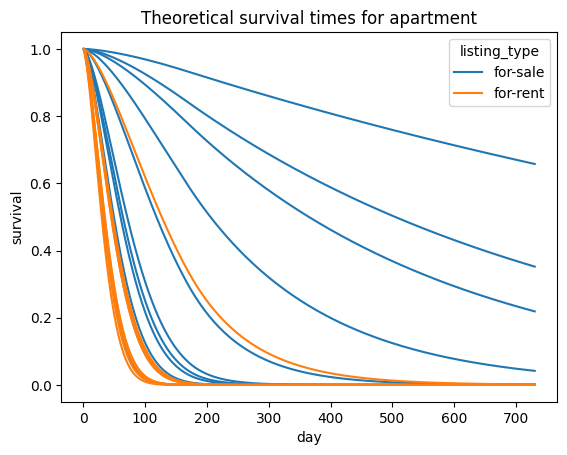

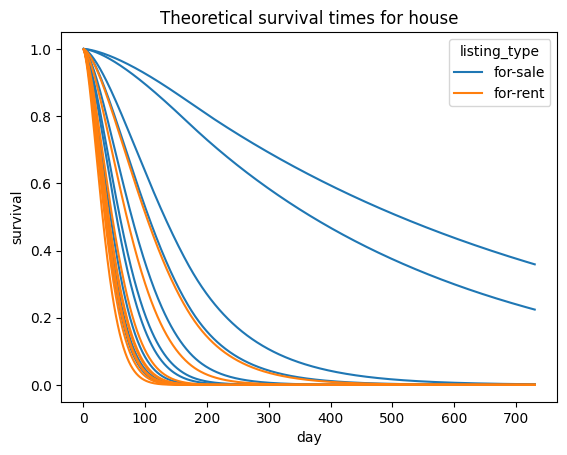

In [27]:
for name, group in df_surv_long.groupby(['property_type']):
    sns.lineplot(x='day', y='survival', data=group, units='id', hue='listing_type', estimator=None)
    plt.title(f"Theoretical survival times for {name[0]}")
    plt.show()

### Root Finding

In [28]:
def quantile_function(day, q=0.8, group=None):
    # Calculate the empirical quantile based on 'day' and 'survival'
    quantile_value = group[group['day'] <= day]['survival'].min()
    return quantile_value - q

# Create a function to apply to each group (each 'id')
def get_quantile(group, target_quantile=0.8):
    try:
        result = brentq(quantile_function, a=1, b=365*2, args=(target_quantile, group))
    except:
        result = np.nan
    return pd.Series({'quantile_80': result})

# Apply the function to each 'id' group and store the results in a new DataFrame
result_df = df_surv_long.groupby(['id']).apply(get_quantile, target_quantile=1-0.9).reset_index().sort_values(by='quantile_80', ascending=False)
result_df

,id,quantile_80
31,bbc4088e4e7cbba703d324c8ada5b063,546.0
4,2011da2968de827348260bb56280236a,307.0
29,b8be75d829530af8470b5b5105bb9c45,293.0
1,09af1e0e9e4c878f4f6411d2be01bf57,269.0
27,a6b31611ba2b8a1e17501d5b679641d3,236.0
24,986cda325f6cfc8352a4e74393963da7,227.0
15,73bfc3683888878b9528baf4de1613d3,170.0
17,79689f6187d4121fc0441f92739ec6da,154.0
21,8f2885d4d7f4fb17a1444c80dff4eefc,153.0
36,d218003bfcc6ff865f6b16357504a285,139.0


# Quantile Prediction

## Predict

In [29]:
# get predictions
df_quantile90_surv = (
    get_extended_survival_df(
        X_test, y_test, 
        xgbse_weibull, 
        ids=test_ids, 
        df=df_model, 
        cols=colnames_x_numeric_tidy, 
        tau=365*2
    )
    .groupby(['listing_type', 'property_type'])
    .sample(500, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'listing_type', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
    .groupby(['id'])
    .apply(get_quantile, target_quantile=1-0.8)
    .reset_index()
    .merge(df_model, how='inner', on='id')
)


## look calibration

### Quantile

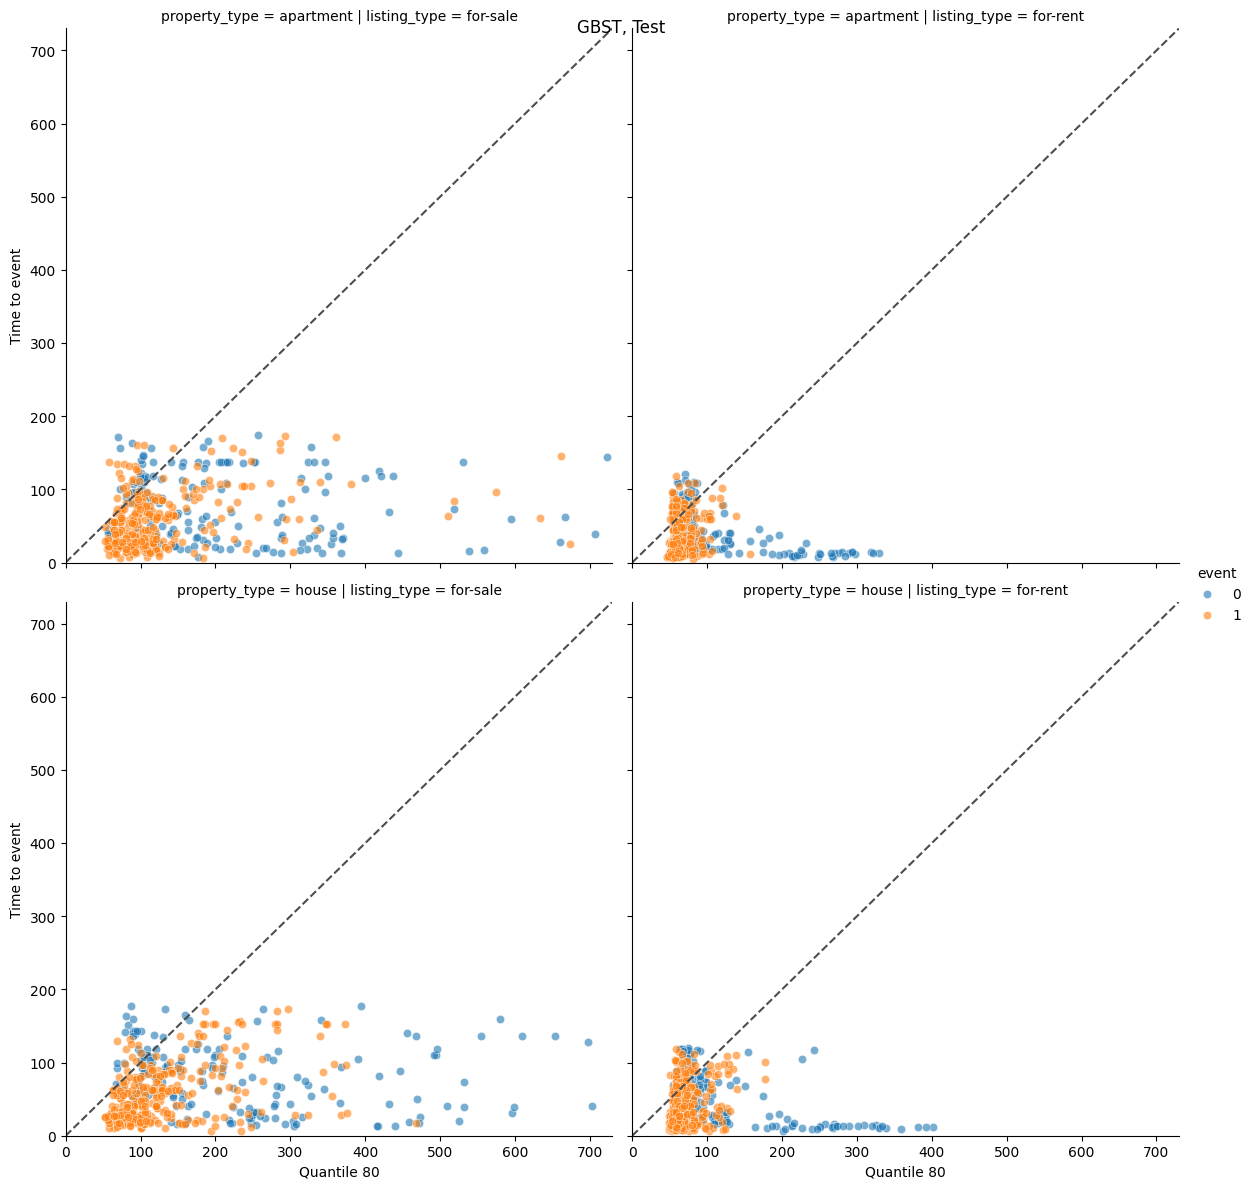

In [30]:
# plot quantile_80 vs time2event, facet grid listing_type and property_type and hue by event
g = sns.FacetGrid(df_quantile90_surv, col='listing_type', row='property_type', hue='event')

# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)

# plot a scatter plot
g.map(sns.scatterplot, 'quantile_80', 'time2event', alpha=0.6)

# extend limits of x axis
g.set(xlim=(0, 365*2), ylim=(0, 365*2))

# Add the identity line to each facet
for ax in g.axes.flat:
    ax.plot([0, 365*2], [0, 365*2], ls="--", c=".3")

g.set_axis_labels('Quantile 80', 'Time to event')
g.fig.suptitle('GBST, Test')

# add legend
g.add_legend()

plt.show()


In [ ]:
# get calibration by listing_type and property_type
(
    df_quantile90_surv
    .assign(
        is_higher=lambda x: np.where(x['time2event'] > x['quantile_80'], 1, 0),
    )
    .groupby(['listing_type', 'property_type', 'event'])
    .agg({'is_higher': 'mean'})
)

is_higher
listing_type property_type event           
for-rent     apartment     0       0.196970
                           1       0.111413
             house         0       0.172185
                           1       0.154728
for-sale     apartment     0       0.121827
                           1       0.079208
             house         0       0.131313
                           1       0.036424

In [32]:
# get calibration by listing_type and property_type
(
    df_quantile90_surv
    .assign(
        is_higher=lambda x: np.where(x['time2event'] > x['quantile_80'], 1, 0),
    )
    .groupby(['event'])
    .agg({'is_higher': 'mean'})
)

,is_higher
event,
0,0.150442
1,0.098336


### Kaplan Mier vs Model

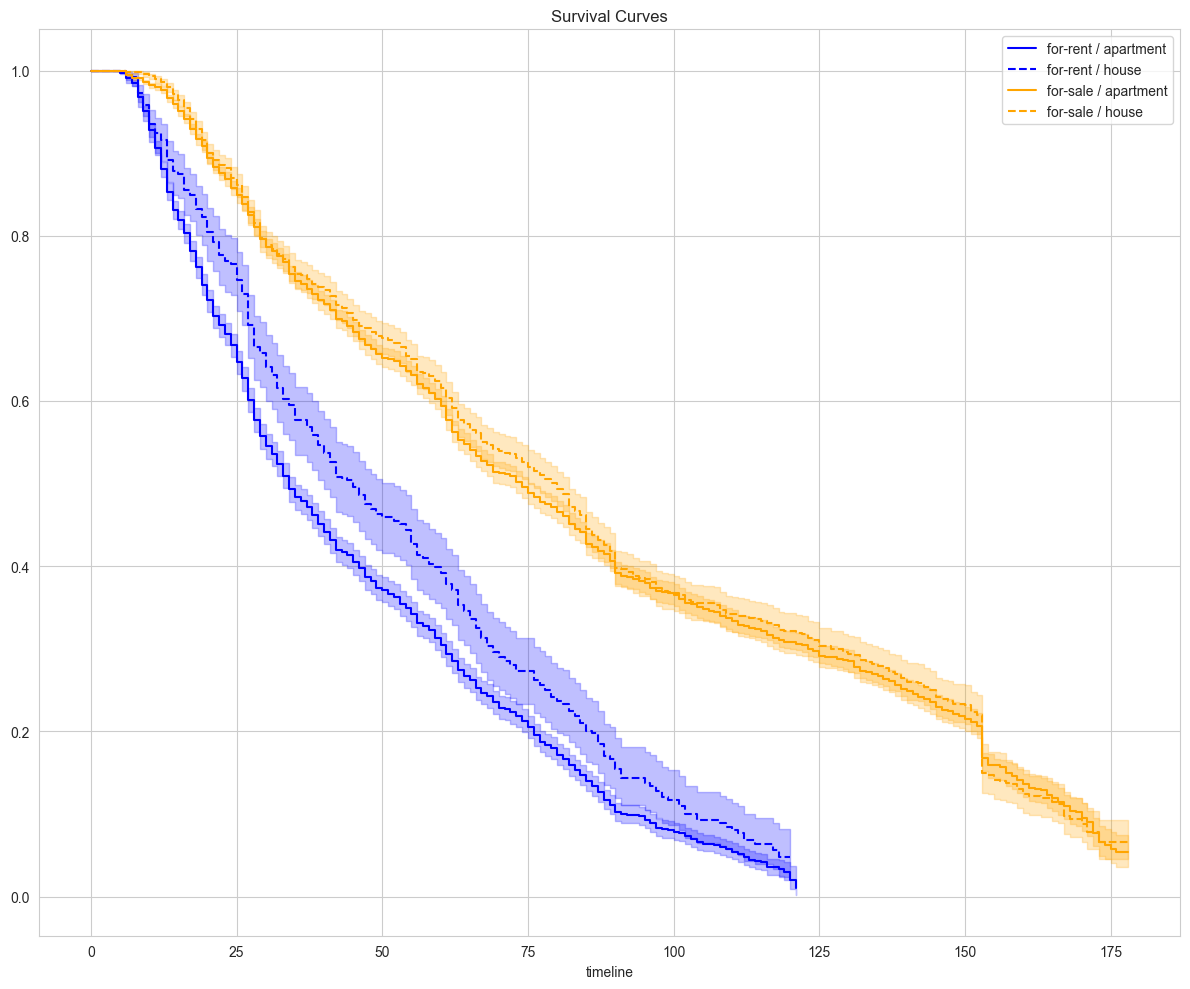

In [ ]:
# create a KM plot for each listing_type and property_type if X_test
# first get dataframe with times
df_test_times = pd.DataFrame({
    'time2event': y_test['Survival_in_days'],
    'event': y_test['Status'],
    'listing_type': X_test[:, 0],
    'property_type': X_test[:, 1],
    'id': test_ids
}).assign(
    listing_type=lambda x: np.where(x['listing_type'] == 1, 'for-sale', 'for-rent'),
    property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
)
df_test_times

# create a KM plot for each listing_type and property_type for df_test_times
def plot_km(df):
    df = df.copy()
    ax = plt.subplot(111)

    dict_km = {}
    for listing_type in ['for-rent', 'for-sale']:
        for property_type in ['apartment', 'house']:
            # get key
            listing_property = "{listing_type} / {property_type}".format(
                listing_type=listing_type, property_type=property_type
                )
            df_rent = df[
                (df['listing_type'] == listing_type) &
                (df['property_type'] == property_type)
                ].copy()
            
            # estimate
            kmf = lifelines.KaplanMeierFitter()
            ax = kmf.fit(
                df_rent['time2event'],
                df_rent['event'],
                label=listing_property
            ).plot_survival_function(
                ci_show=True,
                figsize=(12, 10),
                color=('b' if listing_type == 'for-rent' else 'orange'),
                style=('-' if property_type == 'apartment' else '--'),
                title='Survival Curves'
            )

            # add km to dict
            dict_km[listing_property] = kmf
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    return

plot_km(df_test_times)

In [ ]:
colnames_x_numeric

Index(['listing_type=for-sale', 'property_type=house', 'woe_marketplace',
       'woe_seller', 'woe_id_sepomex', 'first_price', 'diff_first_prediction',
       'prediction_price_per_square_meter', 'surface_total',
       'page_on_marketplace', 'is_new_property_prob', 'total_cost_of_living',
       'days_active', 'relative_cost_of_living', 'is_exterior', 'has_gym',
       'pets_allowed', 'has_maintenance', 'num_bedrooms', 'sine_tmonth',
       'cosine_tmonth', 'latitude', 'longitude'],
      dtype='object')

In [ ]:
# get df test with modified values
df_test_x_numeric = pd.DataFrame(X_test, columns=colnames_x_numeric)
df_test_x_numeric

# apply mean by listing_type and property_type
df_test_x_numeric_artificial = (
    df_test_x_numeric.copy()
    .groupby(["listing_type=for-sale", "property_type=house"])
    .apply('mean')
    .reset_index()
    )

# predict
df_test_extended_surv = (
    extrapolate_constant_risk(
        survival=xgbse_weibull.predict(df_test_x_numeric_artificial.values),
        final_time=365*2,
        intervals=1
    )
    .assign(
        listing_type=df_test_x_numeric_artificial['listing_type=for-sale'].\
            apply(lambda x: 'for-sale' if x == 1 else 'for-rent'),
        property_type=df_test_x_numeric_artificial['property_type=house'].\
            apply(lambda x: 'house' if x == 1 else 'apartment'),
    )
    .melt(id_vars=['listing_type', 'property_type'], value_vars=range(1, 365*2+1))
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .sort_values(by=['listing_type', 'property_type', 'day'])
)
df_test_extended_surv

,listing_type,property_type,day,survival
0,for-rent,apartment,1.0,0.998154
4,for-rent,apartment,2.0,0.994543
8,for-rent,apartment,3.0,0.989725
12,for-rent,apartment,4.0,0.983922
16,for-rent,apartment,5.0,0.977272
...,...,...,...,...
2903,for-sale,house,726.0,0.050512
2907,for-sale,house,727.0,0.050286
2911,for-sale,house,728.0,0.050062
2915,for-sale,house,729.0,0.049838


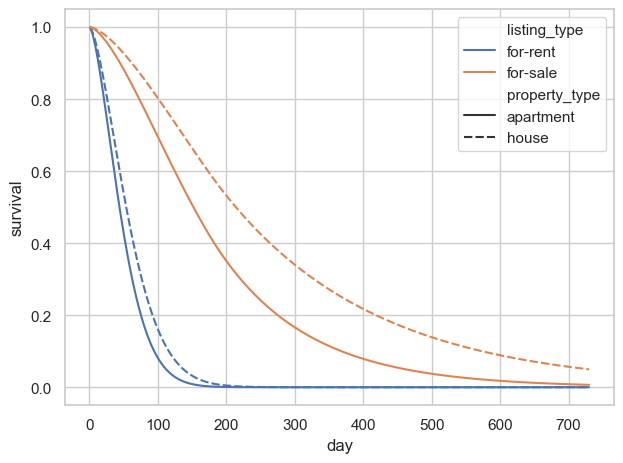

In [ ]:
# plot a lineplot, colored by listing_type and linetype by property_type
sns.set_theme(style="whitegrid")
sns.lineplot(x='day', y='survival', data=df_test_extended_surv, hue='listing_type', style='property_type', estimator=None)
plt.tight_layout()

In [ ]:
# fit a kaplan meier for each listing_type and property_type and then plot
km_fits = {}
for listing_type in ['for-rent', 'for-sale']:
    for property_type in ['apartment', 'house']:
        # get key
        listing_property = "{listing_type} / {property_type}".format(
            listing_type=listing_type, property_type=property_type
            )
        df_rent = df_test_times[
            (df_test_times['listing_type'] == listing_type) &
            (df_test_times['property_type'] == property_type)
            ].copy()
        
        # estimate
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(
            df_rent['time2event'],
            df_rent['event'],
            label=listing_property
        )
        km_fits[listing_property] = kmf

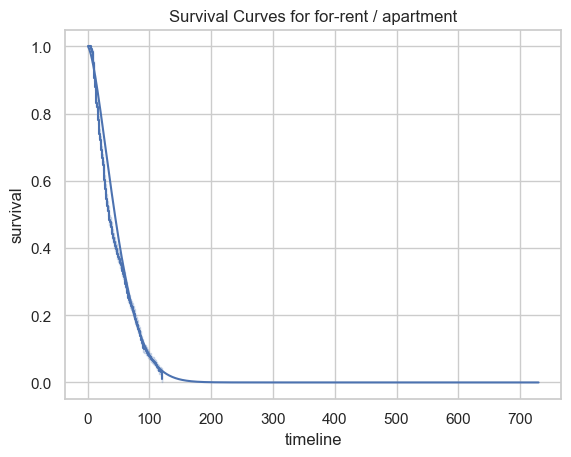

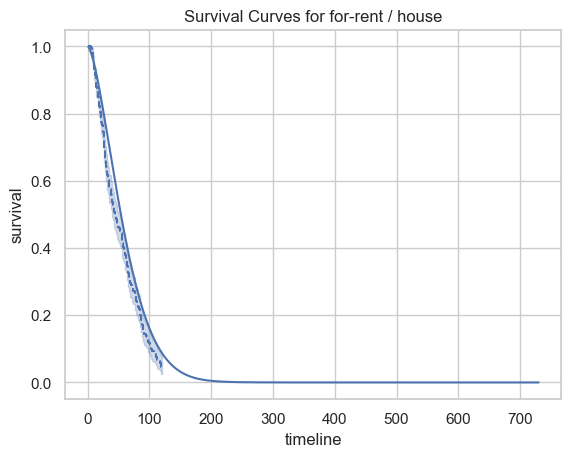

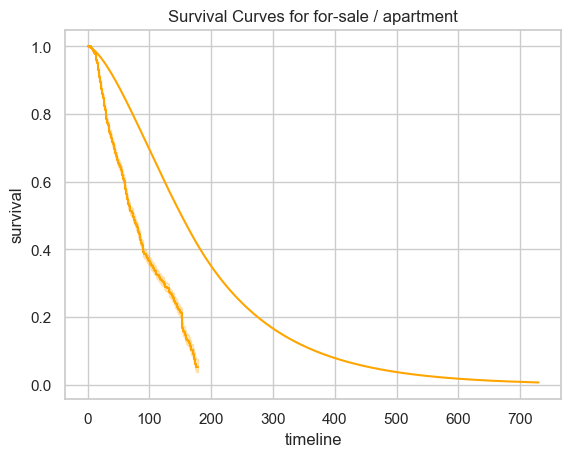

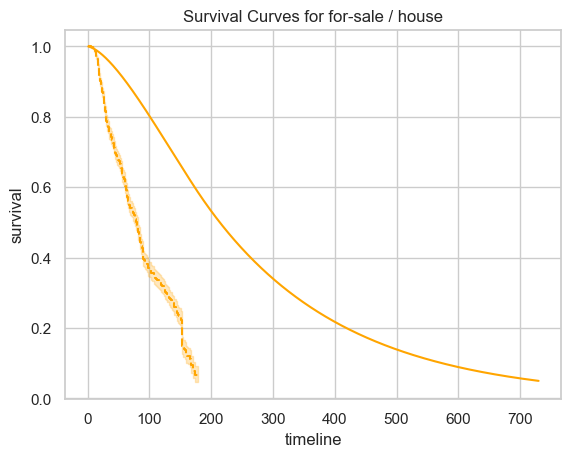

In [ ]:
# plot a lineplot for each listing_type and property_type using the km and df_test_extended_surv
for listing_type in ['for-rent', 'for-sale']:
    for property_type in ['apartment', 'house']:
        # get key
        listing_property = "{listing_type} / {property_type}".format(
            listing_type=listing_type, property_type=property_type
            )
        # plot km
        km_fits[listing_property].plot_survival_function(
            ci_show=True,
            color=('b' if listing_type == 'for-rent' else 'orange'),
            style=('-' if property_type == 'apartment' else '--'),
            title=f'Survival Curves for {listing_property}'
        )
        # plot lineplot
        sns.lineplot(
            x='day', y='survival', 
            data=df_test_extended_surv.query(f"listing_type == '{listing_type}' & property_type == '{property_type}'"), 
            estimator=None,
            color=('b' if listing_type == 'for-rent' else 'orange'),
        )
        # dont show legend
        plt.legend().remove()
        plt.show()









